## Steady-state Single Variable Analysis

In [1]:
import trenchripper as tr

import dask
import warnings
import random
import anndata

import numpy as np
import pandas as pd
import sklearn as skl
import dask.dataframe as dd

from matplotlib import pyplot as plt

random.seed(42)
np.random.seed(42)

warnings.filterwarnings(action='once',category=UserWarning)

# addition of active memory manager
dask.config.set({'distributed.scheduler.active-memory-manager.start': True});
dask.config.set({'distributed.scheduler.worker-ttl': "5m"});
dask.config.set({'distributed.scheduler.allowed-failures': 100});

dask_wd = "/home/de64/scratch/de64/dask"

### Load Functions

In [2]:
def fit_reg(df,bootstrap=True,nbootstraps=500,ci=95):
    #replace r squared with a more meaningful metric like rss or smthn
    
    growth_vals = df["Instantaneous Growth Rate: Volume"].values
    length_vals = df["Length"].values
    
    reg_model = skl.linear_model.LinearRegression()
    reg_model.fit(growth_vals.reshape(-1,1),np.log2(length_vals))
    slope,intercept = reg_model.coef_[0],reg_model.intercept_
    r2 = reg_model.score(growth_vals.reshape(-1,1),np.log2(length_vals))
    
    residuals = reg_model.predict(growth_vals.reshape(-1,1))-np.log2(length_vals)
    mean_abs_residual = np.mean(np.abs(residuals))
    max_length,min_length = np.max(length_vals),np.min(length_vals)
    min_growth,length_at_min_growth = np.min(growth_vals),length_vals[np.argmin(growth_vals)]
    
    if bootstrap:
        reg_model = skl.linear_model.LinearRegression()
        X = growth_vals
        y = np.log2(length_vals)
        bootstrap_idx = np.random.choice(range(X.shape[0]), size=(nbootstraps,X.shape[0]))
        boot_X = X[bootstrap_idx]
        boot_y = y[bootstrap_idx]
        
        num = np.sum((boot_X-np.mean(boot_X,axis=1)[:,np.newaxis])*(boot_y-np.mean(boot_y,axis=1)[:,np.newaxis]),axis=1)
        denom = np.sum((boot_X-np.mean(boot_X,axis=1)[:,np.newaxis])**2,axis=1)
        slopes = num/denom
        slope_diffs = np.abs(slopes-slope)
        slope_diff_ci = np.percentile(slope_diffs,ci)
        output = pd.Series({"Slope":slope,"Intercept":intercept, "R2":r2, "Min Growth":min_growth, "Max Length":max_length, "Min Length":min_length,"Length at Min Growth Rate":length_at_min_growth,\
                            "Mean Abs Residual": mean_abs_residual, "CI": slope_diff_ci})
    else:
        output = pd.Series({"Slope":slope,"Intercept":intercept, "R2":r2, "Min Growth":min_growth, "Max Length":max_length, "Min Length":min_length,"Length at Min Growth Rate":length_at_min_growth,\
                            "Mean Abs Residual": mean_abs_residual})
    return output

### Initial Data Processing

#### Start Dask

In [3]:
dask_controller = tr.trcluster.dask_controller(
    walltime="04:00:00",
    local=False,
    n_workers=100,
    n_workers_min=100,
    memory="16GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

230m
04:00:00


In [3]:
dask_controller.daskclient

NameError: name 'dask_controller' is not defined

## Cell Cycle Analysis

### Import Necessary Dataframes

In [5]:
cell_cycle_df = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2023-01-18_lDE20_Lineage_Cell_Cycle_Merged/", engine="pyarrow",calculate_divisions=True)
timepoints_df = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2023-01-18_lDE20_Lineage_Observations_Merged/", engine="pyarrow",calculate_divisions=True)
growth_df = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2023-01-18_lDE20_Lineage_Growth_Observations_Merged/", engine="pyarrow",calculate_divisions=True)

#### Select Parameters to Analyze

In [6]:
cell_cycle_columns = ['Multi-Experiment Global CellID', 'Multi-Experiment FOV', 'Global CellID', 'phenotype trenchid', 'File Parquet Index', 'fov',\
       'row', 'trench', 'initial timepoints', 'Mother', 'CellID', 'Mother CellID', 'Daughter CellID 1', 'Daughter CellID 2', 'Sister CellID',\
                      'Experiment #', 'Birth: Length', 'Division: Length',\
                      'Delta: Length', 'Septum Displacement Length Normalized', 'Birth: Volume', 'Division: Volume', 'Delta: Volume',\
                      'Final time (s)','Initial time (s)','Delta time (s)','Growth Rate: Length','Growth Rate: Volume']
timepoints_columns = ['Global CellID-Cell Cycle timepoints', 'phenotype trenchid', 'Global CellID', 'Observation time (s)', 'Length',\
                     'Width', 'mCherry mean_intensity', 'Experiment #', 'Multi-Experiment Global CellID']
growth_columns = ['Global CellID-Growth Rate Measurement Index', 'phenotype trenchid', 'Global CellID', 'Measurement time (s)',\
                  'Instantaneous Growth Rate: Length', 'Instantaneous Growth Rate: Volume', 'Experiment #', 'Multi-Experiment Global CellID']

cell_cycle_df = cell_cycle_df[cell_cycle_columns]
timepoints_df = timepoints_df[timepoints_columns]
growth_df = growth_df[growth_columns]

### Classify proliferating cells
- Classify trenches as proliferating or non-proliferating and exclude from subsequent analysis where appropriate
- Proliferation criterion:
    - Median instantanous growth rate for the trench must give a doubling time of at least once every 3 hours, that is $ \lambda > \frac{\ln(2)}{3} \frac{1}{hr} $ 
    - Median doubling time (for reported cell cycles) must give a doubling time of at least once every 3 hours
    - The number of cell cycle reports (of the mother cell only) must also average out to once every 3 hours

In [7]:
induction_time = 2*3600
steady_state_time = 7*3600
final_time = 10*3600
steady_state_interval = final_time-steady_state_time

doubling_threshold = 3
growth_rate_threshold = np.log(2)/doubling_threshold
doubling_time_threshold = doubling_threshold*3600
# n_mother_cycles = int(np.ceil(steady_state_interval/doubling_time_threshold))

In [8]:
cell_cycle_df_ss = cell_cycle_df[cell_cycle_df["Initial time (s)"]>=steady_state_time][["Delta time (s)","Mother"]]
growth_df_ss = growth_df[growth_df["Measurement time (s)"]>=steady_state_time][["Instantaneous Growth Rate: Volume"]]

median_growth_rate_series = growth_df_ss.groupby("Multi-Experiment Phenotype Trenchid")["Instantaneous Growth Rate: Volume"].apply(lambda x: np.nanmedian(x)).compute()
median_doubling_time_series = cell_cycle_df_ss.groupby("Multi-Experiment Phenotype Trenchid")["Delta time (s)"].apply(lambda x: np.nanmedian(x)).compute()
n_cell_cycles_series = cell_cycle_df_ss[cell_cycle_df_ss["Mother"]==True].groupby("Multi-Experiment Phenotype Trenchid").size().compute()

/tmp/ipykernel_31543/3455830797.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  median_growth_rate_series = growth_df_ss.groupby("Multi-Experiment Phenotype Trenchid")["Instantaneous Growth Rate: Volume"].apply(lambda x: np.nanmedian(x)).compute()
/tmp/ipykernel_31543/3455830797.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  median_doubling_time_series = cell_cycle_df_ss.groupby("Multi-Experiment Phenotype Trenchid")["Delta time (s)"].apply(lambda x: np.nanmedian(x)).compute()


In [9]:
trenches_above_growth_thr = median_growth_rate_series>growth_rate_threshold
trenches_below_doubling_thr = median_doubling_time_series<doubling_time_threshold
# trenches_above_n_cycles_thr = n_cell_cycles_series>n_mother_cycles
proliferating_trench_df = pd.concat([trenches_above_growth_thr,trenches_below_doubling_thr],join="inner",axis=1)
proliferating_trench_df["Proliferating"] = np.all(proliferating_trench_df.values, axis=1)
proliferating_trench_df = proliferating_trench_df.drop(["Instantaneous Growth Rate: Volume","Delta time (s)"], axis=1)
cell_cycle_df = cell_cycle_df.join(proliferating_trench_df,how="inner").persist()
wait(cell_cycle_df);

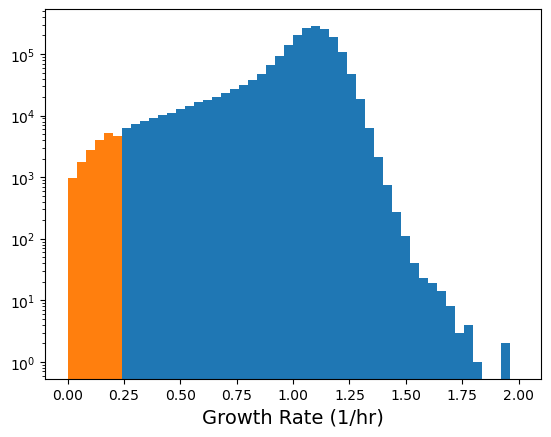

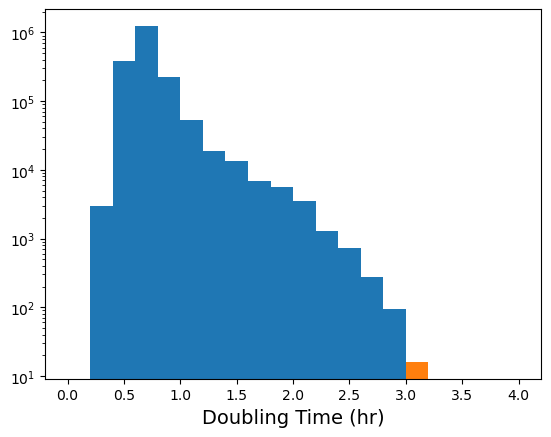

In [10]:
plt.hist(median_growth_rate_series[median_growth_rate_series>growth_rate_threshold],bins=50,log=True,range=(0,2))
plt.hist(median_growth_rate_series[median_growth_rate_series<=growth_rate_threshold],bins=50,log=True,range=(0,2))
plt.xlabel("Growth Rate (1/hr)",fontsize=14)
plt.show()

plt.hist(median_doubling_time_series[median_doubling_time_series<=doubling_time_threshold]/3600,bins=20,log=True,range=(0,4))
plt.hist(median_doubling_time_series[median_doubling_time_series>doubling_time_threshold]/3600,bins=20,log=True,range=(0,4))
plt.xlabel("Doubling Time (hr)",fontsize=14)
plt.show()

In [11]:
frac_proliferating = np.sum(proliferating_trench_df["Proliferating"])/len(proliferating_trench_df)
print(frac_proliferating)

0.9993732548809569


#### Add sgRNA info for real data

In [12]:
final_output_df_barcodes = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2023-01-18_lDE20_Final_Barcodes_df_Merged",engine="pyarrow",calculate_divisions=True).persist()
wait(final_output_df_barcodes);
final_output_df_barcodes = final_output_df_barcodes.set_index("Multi-Experiment Phenotype Trenchid",sorted=True).groupby("Multi-Experiment Phenotype Trenchid",sort=False).apply(lambda x: x.iloc[0]).persist()
wait(final_output_df_barcodes);
final_output_df_barcodes = final_output_df_barcodes.reset_index().set_index("oDEPool7_id",drop=True)
final_output_df_barcodes = final_output_df_barcodes.reset_index().set_index("Multi-Experiment Phenotype Trenchid").persist()
wait(final_output_df_barcodes);
final_output_df_barcodes = final_output_df_barcodes[['oDEPool7_id','Barcode','sgRNA','Closest Hamming Distance', 'EcoWG1_id', 'Gene', 'N Mismatch', 'Category', 'TargetID', 'barcodeid']]
wait(final_output_df_barcodes);
cell_cycle_df = cell_cycle_df.join(final_output_df_barcodes)
timepoints_df = timepoints_df.join(final_output_df_barcodes)
growth_df = growth_df.join(final_output_df_barcodes)

/home/de64/micromamba/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:5252: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/tmp/ipykernel_31543/2136909752.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  final_output_df_barcodes = final_output_df_barcodes.set_index("Multi-Experiment Phenotype Trenchid",sorted=True).groupby("Multi-Experiment Phenotype Trenchid",sort=False).apply(lambda x: x.iloc[0]).persist()


In [13]:
cell_cycle_df_only_proliferating = cell_cycle_df[cell_cycle_df["Proliferating"]]

n_obs_cell_cycle = cell_cycle_df.groupby("oDEPool7_id",sort=False).apply(lambda x: len(x.index.unique()), meta=int).compute()
n_obs_cell_cycle = pd.DataFrame(n_obs_cell_cycle).rename({0:"N Observations"}, axis=1).sort_index()
n_obs_cell_cycle_prolif = cell_cycle_df_only_proliferating.groupby("oDEPool7_id",sort=False).apply(lambda x: len(x.index.unique()), meta=int).compute()
n_obs_cell_cycle_prolif = pd.DataFrame(n_obs_cell_cycle_prolif).rename({0:"N Observations Proliferating"}, axis=1).sort_index()
n_obs_cell_cycle_df = pd.concat([n_obs_cell_cycle,n_obs_cell_cycle_prolif],axis=1)
n_obs_cell_cycle_df.loc[np.isnan(n_obs_cell_cycle_df["N Observations Proliferating"]),"N Observations Proliferating"] = 0
n_obs_cell_cycle_df["N Observations Proliferating"] = n_obs_cell_cycle_df["N Observations Proliferating"].astype(int)
cell_cycle_df = cell_cycle_df.join(n_obs_cell_cycle_df,on="oDEPool7_id")

n_obs_timepoints = timepoints_df.groupby("oDEPool7_id",sort=False).apply(lambda x: len(x.index.unique()), meta=int).compute()
n_obs_timepoints = pd.DataFrame(n_obs_timepoints).rename({0:"N Observations"}, axis=1).sort_index()
timepoints_df = timepoints_df.join(n_obs_timepoints,on="oDEPool7_id")

n_obs_growth = growth_df.groupby("oDEPool7_id",sort=False).apply(lambda x: len(x.index.unique()), meta=int).compute()
n_obs_growth = pd.DataFrame(n_obs_growth).rename({0:"N Observations"}, axis=1).sort_index()
growth_df = growth_df.join(n_obs_growth,on="oDEPool7_id")

/home/de64/micromamba/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:7086: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/micromamba/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:7086: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/micromamba/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:7086: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple represent

### Determine when cells reach steady state and save intermediate df as a checkpoint

In [14]:
cell_cycle_df_ss = cell_cycle_df[cell_cycle_df["Initial time (s)"]>=steady_state_time]
cell_cycle_df_preinduction = cell_cycle_df[cell_cycle_df["Final time (s)"]<=induction_time]
cell_cycle_df = cell_cycle_df.reset_index().set_index("Multi-Experiment Phenotype Trenchid",sorted=True).repartition(npartitions=400)
cell_cycle_df_ss.to_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df/", engine="pyarrow", overwrite=True)
cell_cycle_df_preinduction.to_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Cell_Cycle_df/", engine="pyarrow", overwrite=True)

timepoints_df_ss = timepoints_df[timepoints_df["Observation time (s)"]>=steady_state_time]
timepoints_df_preinduction = timepoints_df[timepoints_df["Observation time (s)"]<=induction_time]
timepoints_df = timepoints_df.reset_index().set_index("Multi-Experiment Phenotype Trenchid",sorted=True).repartition(npartitions=400)
timepoints_df_ss.to_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df/", engine="pyarrow", overwrite=True)
timepoints_df_preinduction.to_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Timepoints_df/", engine="pyarrow", overwrite=True)

growth_df_ss = growth_df[growth_df["Measurement time (s)"]>=steady_state_time]
growth_df_preinduction = growth_df[growth_df["Measurement time (s)"]<=induction_time]
growth_df = growth_df.reset_index().set_index("Multi-Experiment Phenotype Trenchid",sorted=True).repartition(npartitions=400)
growth_df_ss.to_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df/", engine="pyarrow", overwrite=True)
growth_df_preinduction.to_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Growth_df/", engine="pyarrow", overwrite=True)
dask_controller.reset_worker_memory()

## Computing Trench-wise Estimator Distributions

- These distributions can be used to construct confidence intervals (this will help with clustering)
- They can also be re-used to compute p-values (with some modification)

### Estimators of Interest

- Mean
- Median
- CV
- MAD CV
- Pearson R
- Qn (Pearson R)

### Bootstraps of Interest

- Naive Bootstrap
- Tapered Block Bootstrap
    - Using for ACFs
- Stationary Bootstrap
    - Using for location, scale and pearson correlation (single cell cycle)

## 1) Computing Estimators
- Actually computes estimators for different steady state values
- Will be merged with p-values, CIs and variances from bootstrapping

In [4]:
dask_controller = tr.trcluster.dask_controller(
    walltime="03:00:00",
    local=False,
    n_workers=200,
    n_workers_min=100,
    memory="16GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

170m
03:00:00


In [ ]:
dask_controller.daskclient

### Reload Dataframes

In [15]:
cell_cycle_df_ss = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df/", engine="pyarrow",calculate_divisions=True)
cell_cycle_df_preinduction = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Cell_Cycle_df/", engine="pyarrow",calculate_divisions=True)

timepoints_df_ss = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df/", engine="pyarrow",calculate_divisions=True)
timepoints_df_preinduction = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Timepoints_df/", engine="pyarrow",calculate_divisions=True)

growth_df_ss = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df/", engine="pyarrow",calculate_divisions=True)
growth_df_preinduction = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Growth_df/", engine="pyarrow",calculate_divisions=True)

### 1a) Calculate Location, Scale and Correlation Estimates

In [16]:
steady_state_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df"
preinduction_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Cell_Cycle_df"
single_variable_list = ['Septum Displacement Length Normalized','Delta time (s)']
bivariate_variable_list = []

tr.export_estimator_df(steady_state_df_path,preinduction_df_path,single_variable_list,bivariate_variable_list,filter_proliferating=True,\
                    final_columns=['oDEPool7_id', 'sgRNA','EcoWG1_id', 'Gene', 'N Mismatch', 'Category', 'TargetID', 'N Observations', 'N Observations Proliferating'])

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:755: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  trench_estimator_df = trench_groupby.apply(lambda x: get_estimator_df_single_trench(x,param_groups,estimator,\
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:755: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  trench_estimator_df = trench_groupby.apply(lambda x: get_estimator_df_single_trench(x,param_groups,estimator,\


In [23]:
steady_state_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df"
preinduction_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Timepoints_df"
single_variable_list = ['Length', 'Width', 'mCherry mean_intensity']
bivariate_variable_list = []

tr.export_estimator_df(steady_state_df_path,preinduction_df_path,single_variable_list,bivariate_variable_list,filter_proliferating=False,\
                   final_columns=['oDEPool7_id', 'sgRNA','EcoWG1_id', 'Gene', 'N Mismatch', 'Category', 'TargetID', 'N Observations'])

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:681: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimator_output[final_columns] = trench_df[final_columns].iloc[0]
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:681: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimator_output[final_columns] = trench_df[final_columns].iloc[0]
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:681: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a futur

In [24]:
steady_state_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df"
preinduction_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Growth_df"
single_variable_list = ['Instantaneous Growth Rate: Volume']
bivariate_variable_list = []

tr.export_estimator_df(steady_state_df_path,preinduction_df_path,single_variable_list,bivariate_variable_list,filter_proliferating=False,\
                   final_columns=['oDEPool7_id', 'sgRNA','EcoWG1_id', 'Gene', 'N Mismatch', 'Category', 'TargetID', 'N Observations'])

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:681: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimator_output[final_columns] = trench_df[final_columns].iloc[0]
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:681: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimator_output[final_columns] = trench_df[final_columns].iloc[0]
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:681: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a futur

## 2) Bootstrapping Estimators
- Computing estimator bootstraps
- Using this, find: $ var(\hat\theta) $, percentile confidence intervals, and p-values

### 2a)  Bootstrapping Procedure


- First, saving a repartitioned version of the sgRNA sorted dataframe
- Then, running the aggregate bootstrapper on the trenches individually and saving the output
- Finally aggregating on the whole dataset (for the parameters and estimators of interest) and outputting the samples for later manipulation
- Of particular interest is comparing different estimators for robust measures of location, scale and the pearson correlation

#### On Bootstrapping Choices

- For the location, scale and correlation estimation, I am using a stationary bootstrap since it could be defined for entire trenches of data (i.d. mother and first daughter lineages)
- For the ACF estimation, it is necessary to use the tapered block bootstrap since the stationary bootstrap adds biases to the ACF estimation
- A drawback of this approach is that I may only use mother cells in the tapered case

### Exports Trench-wise Bootstrap (For Location, Scale and Correlation Estimators)
- Using a standard bootstrap for everything in this notebook because the timeseries is too short for the other methods

### Start a Dask For Each (since it crashes)

In [3]:
dask_controller = tr.trcluster.dask_controller(
    walltime="06:00:00",
    local=False,
    n_workers=200,
    n_workers_min=200,
    memory="16GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

350m
06:00:00


In [4]:
dask_controller.daskclient

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.120.16.236:8787/status,
Dashboard: http://10.120.16.236:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.120.16.236:36496,Workers: 0
Dashboard: http://10.120.16.236:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
n_bootstraps_trench_density = 100
n_bootstraps_trench_aggregate = 1000
overwrite = True

estimators = [np.nanmean]
estimator_names = ["Mean"]
bivariate_variable_list = [False]
estimator_names_to_agg = ["Mean","Mean"]
unpaired_aggregators=[np.nanmedian,np.nanmean]
paired_aggregators=[]
agg_names=["Mean (Robust)","Mean (True)"]

single_variable_list = ['Septum Displacement Length Normalized','Delta time (s)']
pearsonr_variable_list = []

steady_state_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df"
preinduction_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Cell_Cycle_df"

tr.trenchwise_bootstrap_main(dask_controller,steady_state_df_path,preinduction_df_path,tr.bootstrap_density,estimators,estimator_names,bivariate_variable_list,\
                              single_variable_list,pearsonr_variable_list,filter_proliferating=True,n_bootstraps_trench_density=n_bootstraps_trench_density,\
                          overwrite=overwrite)

0
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df_temp_filtered
Starting Run.
Done.
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Cell_Cycle_df_temp_filtered
Starting Run.
Done.
1
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df_Trench_Estimator_Bootstrap_temp
Starting Run.
Done.
2
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Cell_Cycle_df_Trench_Estimator_Bootstrap_temp
Starting Run.
Done.
3
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df_Trench_Estimator_Bootstrap
Starting Run.
Done.
4
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df_Trench_Estimator_Bootstrap_temp_2
Starting Run.
Done.
Done!


In [6]:
tr.trench_aggregate_bootstrap_main(dask_controller,steady_state_df_path,estimator_names,bivariate_variable_list,estimator_names_to_agg,unpaired_aggregators,paired_aggregators,\
                           agg_names,single_variable_list,pearsonr_variable_list,n_bootstraps_trench_aggregate=n_bootstraps_trench_aggregate,overwrite=overwrite)

0
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df_Variant_Estimator_Bootstrap_temp
Starting Run.
Done.
1
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df_Variant_Estimator_Bootstrap
Starting Run.
Done.
2
Done!


In [105]:
single_variable_list = ['Length', 'Width','mCherry mean_intensity']
pearsonr_variable_list = []

steady_state_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df"
preinduction_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Timepoints_df"

tr.trenchwise_bootstrap_main(dask_controller,steady_state_df_path,preinduction_df_path,tr.bootstrap_density,estimators,estimator_names,bivariate_variable_list,\
                              single_variable_list,pearsonr_variable_list,filter_proliferating=False,\
                          n_bootstraps_trench_density=n_bootstraps_trench_density,overwrite=overwrite)

0
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df_temp_filtered
Starting Run.
Done.
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Timepoints_df_temp_filtered
Starting Run.
Done.
1
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df_Trench_Estimator_Bootstrap_temp
Starting Run.
Done.
2
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Timepoints_df_Trench_Estimator_Bootstrap_temp
Starting Run.
Done.
3
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df_Trench_Estimator_Bootstrap_temp_2
Starting Run.
Done.
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df_Trench_Estimator_Bootstrap
Starting Run.
Done.
4
/home/de64/scratch/de64/sync_folder/202

In [106]:
tr.trench_aggregate_bootstrap_main(dask_controller,steady_state_df_path,estimator_names,bivariate_variable_list,estimator_names_to_agg,unpaired_aggregators,paired_aggregators,\
                           agg_names,single_variable_list,pearsonr_variable_list,n_bootstraps_trench_aggregate=n_bootstraps_trench_aggregate,overwrite=overwrite)

0
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df_Variant_Estimator_Bootstrap_temp
Starting Run.
Done.
1
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df_Variant_Estimator_Bootstrap
Starting Run.
Done.
2
Done!


In [107]:
single_variable_list = ['Instantaneous Growth Rate: Volume']
pearsonr_variable_list = []

steady_state_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df"
preinduction_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Growth_df"

tr.trenchwise_bootstrap_main(dask_controller,steady_state_df_path,preinduction_df_path,tr.bootstrap_density,estimators,estimator_names,bivariate_variable_list,\
                              single_variable_list,pearsonr_variable_list,filter_proliferating=False,\
                          n_bootstraps_trench_density=n_bootstraps_trench_density,overwrite=overwrite)

0
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df_temp_filtered
Starting Run.
Done.
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Growth_df_temp_filtered
Starting Run.
Done.
1
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df_Trench_Estimator_Bootstrap_temp
Starting Run.
Done.
2
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Growth_df_Trench_Estimator_Bootstrap_temp
Starting Run.
Done.
3
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df_Trench_Estimator_Bootstrap_temp_2
Starting Run.
Done.
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df_Trench_Estimator_Bootstrap
Starting Run.
Done.
4
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Ana

In [108]:
tr.trench_aggregate_bootstrap_main(dask_controller,steady_state_df_path,estimator_names,bivariate_variable_list,estimator_names_to_agg,unpaired_aggregators,paired_aggregators,\
                           agg_names,single_variable_list,pearsonr_variable_list,n_bootstraps_trench_aggregate=n_bootstraps_trench_aggregate,overwrite=overwrite)

0
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df_Variant_Estimator_Bootstrap_temp
Starting Run.
Done.
1
/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df_Variant_Estimator_Bootstrap
Starting Run.
Done.
2
Done!


### 2b) Bootstrapping Controls to Compute P-values (location, scale, correlation)

- Currently replacing with paired tests
- Need to:
    - Add estimation of test statistics in the point estimate setting (earlier)
    - Edit control bootstrap to aggregate appropriate test statistics
    - Finally repair the comparison to generate the correct p-values
- For the point estimation, adding a reserved column for each test statistic should work
    - To do this, need to add the initial dataframe
- Control bootstrap should just be switched for the chosen test statistic (since it is computationally intensive)

In [56]:
dask_controller = tr.trcluster.dask_controller(
    walltime="06:00:00",
    local=False,
    n_workers=100,
    n_workers_min=100,
    memory="16GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

350m
06:00:00


In [57]:
dask_controller.daskclient

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.120.16.171:8787/status,
Dashboard: http://10.120.16.171:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.120.16.171:43556,Workers: 0
Dashboard: http://10.120.16.171:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [48]:
# bootstrap_block_len = 4
n_bootstraps_trench_density = 1000
# n_bootstraps_trench_aggregate = 250000
n_bootstraps_trench_aggregate = 100000
filter_proliferating = True

estimators = [np.nanmean]
estimator_names = ["Mean"]
bivariate_variable_list = [False]
estimator_names_to_agg = ["Mean","Mean"]
unpaired_aggregators=[np.nanmedian,np.nanmean]
paired_aggregators=[]

agg_names=["Mean (Robust)","Mean (True)"]

single_variable_list = ['Septum Displacement Length Normalized','Delta time (s)']
## Add More Later, once I have settled on the list
pearsonr_variable_list = []

steady_state_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df"
preinduction_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Cell_Cycle_df"

tr.trench_bootstrap_null_model_main(dask_controller,steady_state_df_path,preinduction_df_path,tr.bootstrap_density,estimators,estimator_names,bivariate_variable_list,\
                              single_variable_list,pearsonr_variable_list,filter_proliferating=filter_proliferating,n_bootstraps_trench_density=n_bootstraps_trench_density)
tr.trench_aggregate_bootstrap_null_model_main(dask_controller,steady_state_df_path,estimator_names,bivariate_variable_list,estimator_names_to_agg,unpaired_aggregators,paired_aggregators,\
                           agg_names,single_variable_list,pearsonr_variable_list,n_bootstraps_trench_aggregate=n_bootstraps_trench_aggregate)

/home/de64/micromamba/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:7086: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/micromamba/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:7086: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:1446: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(fu

In [58]:
n_bootstraps_trench_density = 1000
# n_bootstraps_trench_aggregate = 250000
n_bootstraps_trench_aggregate = 100000
filter_proliferating = False

estimators = [np.nanmean]
estimator_names = ["Mean"]
bivariate_variable_list = [False]
estimator_names_to_agg = ["Mean","Mean"]
unpaired_aggregators=[np.nanmedian,np.nanmean]
paired_aggregators=[]

agg_names=["Mean (Robust)","Mean (True)"]

single_variable_list = ['Length', 'Width','mCherry mean_intensity']
pearsonr_variable_list = []

steady_state_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df"
preinduction_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Timepoints_df"

tr.trench_bootstrap_null_model_main(dask_controller,steady_state_df_path,preinduction_df_path,tr.bootstrap_density,estimators,estimator_names,bivariate_variable_list,\
                              single_variable_list,pearsonr_variable_list,filter_proliferating=filter_proliferating,n_bootstraps_trench_density=n_bootstraps_trench_density)
tr.trench_aggregate_bootstrap_null_model_main(dask_controller,steady_state_df_path,estimator_names,bivariate_variable_list,estimator_names_to_agg,unpaired_aggregators,paired_aggregators,\
                           agg_names,single_variable_list,pearsonr_variable_list,n_bootstraps_trench_aggregate=n_bootstraps_trench_aggregate)

/home/de64/micromamba/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:7086: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/micromamba/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:7086: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:1446: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(fu

In [50]:
n_bootstraps_trench_density = 1000
# n_bootstraps_trench_aggregate = 250000
n_bootstraps_trench_aggregate = 100000
filter_proliferating = False

estimators = [np.nanmean]
estimator_names = ["Mean"]
bivariate_variable_list = [False]
estimator_names_to_agg = ["Mean","Mean"]
unpaired_aggregators=[np.nanmedian,np.nanmean]
paired_aggregators=[]

agg_names=["Mean (Robust)","Mean (True)"]

single_variable_list = ['Instantaneous Growth Rate: Volume']
pearsonr_variable_list = []

steady_state_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df"
preinduction_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Preinduction_Growth_df"

tr.trench_bootstrap_null_model_main(dask_controller,steady_state_df_path,preinduction_df_path,tr.bootstrap_density,estimators,estimator_names,bivariate_variable_list,\
                              single_variable_list,pearsonr_variable_list,filter_proliferating=filter_proliferating,n_bootstraps_trench_density=n_bootstraps_trench_density)
tr.trench_aggregate_bootstrap_null_model_main(dask_controller,steady_state_df_path,estimator_names,bivariate_variable_list,estimator_names_to_agg,unpaired_aggregators,paired_aggregators,\
                           agg_names,single_variable_list,pearsonr_variable_list,n_bootstraps_trench_aggregate=n_bootstraps_trench_aggregate)

/home/de64/micromamba/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:7086: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/micromamba/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:7086: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:1446: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(fu

## 3) Combining Estimates and Bootstraps
- Combine the information from the last two steps to get $ var(\hat\theta) $, confidence intervals and p-values
- Part 1: Computing $ var(\hat\theta) $ and Confidence Intervals from Bootstraps
- Part 2: Computing P-values from Control Bootstraps
- Part 3: Assembling variances, CIs and P-values into single variant dataframe for export

In [1]:
dask_controller = tr.trcluster.dask_controller(
    walltime="03:00:00",
    local=False,
    n_workers=50,
    n_workers_min=50,
    memory="8GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

NameError: name 'tr' is not defined

In [2]:
dask_controller.daskclient

NameError: name 'dask_controller' is not defined

In [59]:
steady_state_cell_cycle_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Cell_Cycle_df"
steady_state_timepoints_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Timepoints_df"
steady_state_growth_df_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_Growth_df"

estimator_cell_cycle_stats_path = steady_state_cell_cycle_df_path + "_Estimators_wStats.pkl"
estimator_timepoints_stats_path = steady_state_timepoints_df_path + "_Estimators_wStats.pkl"
estimator_cell_growth_path = steady_state_growth_df_path + "_Estimators_wStats.pkl"

steady_state_estimator_path = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl"
steady_state_estimator_path_csv = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.csv"

tr.get_final_bootstrap_output(steady_state_cell_cycle_df_path,include_ccf=False,filter_proliferating=True)
tr.get_final_bootstrap_output(steady_state_timepoints_df_path,include_ccf=False,filter_proliferating=False)
tr.get_final_bootstrap_output(steady_state_growth_df_path,include_ccf=False,filter_proliferating=False)

cell_cycle_estimator_df = pd.read_pickle(estimator_cell_cycle_stats_path)
timepoints_estimator_df = pd.read_pickle(estimator_timepoints_stats_path)
growth_estimator_df = pd.read_pickle(estimator_cell_growth_path)

estimator_df = pd.concat([cell_cycle_estimator_df,timepoints_estimator_df,growth_estimator_df]).sort_index()
estimator_df.to_pickle(steady_state_estimator_path)
estimator_df.to_csv(steady_state_estimator_path_csv)

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:1622: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  control_variant_bootstrap_pval_calc_df = control_variant_bootstrap_dd.groupby("Estimator-Variable(s)-NTrenches").apply(lambda x: x["Aggregate Values"].tolist()).persist()
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/steadystate.py:1622: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  control_variant_bootstrap_pval_calc_df = control_

In [ ]:
dask_controller.shutdown()

## 4) Generate Filtered SS Mean Dataset, Map to Clustering Dataframe

### Filtered SS Mean Dataset

In [76]:
## Choose a minimum of 8 trenches based on: 
## https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method

steady_state_estimator_path="/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl"
steady_state_estimator_filtered_path="/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/2024-01-25_lDE20_Steady_State_df_Robust_Mean_Filtered.pkl"
andf_path_to_merge = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2023-02-26_lDE20_10Hour_Analysis/Z_Score_Thr_1.0_N_Neighbors_10/AnnData.h5ad"
andf_path_out = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2023-02-26_lDE20_10Hour_Analysis/Z_Score_Thr_1.0_N_Neighbors_10/AnnData_wSteadyState.h5ad"

estimator_to_export = "Mean (Robust)"
var_name = "oDEPool7_id"
final_ss_columns = ["Gene","Category"]
prolif_parameters_to_filter = ['Delta time (s)','Septum Displacement Length Normalized']
min_n_observations = 8
mean_frac_sem_thr = 0.2

ss_estimators_df = pd.read_pickle(steady_state_estimator_path)
ss_estimators_df = ss_estimators_df.loc[estimator_to_export]

final_column_df = ss_estimators_df.reset_index().groupby(var_name).first()[final_ss_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
ss_estimators_df = ss_estimators_df.reset_index().set_index([var_name])

##hack to get both observations and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=[var_name])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=[var_name])
ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df.loc[ss_estimators_df["N Observations Proliferating"]<min_n_observations,\
prolif_parameters_to_filter + [param + " SEM" for param in prolif_parameters_to_filter]] = np.NaN
ss_estimators_df = ss_estimators_df.join(final_column_df)

##write
ss_estimators_df.to_pickle(steady_state_estimator_filtered_path)

### Mapping Steady State Values to Clustering Dataframe

In [77]:
ss_estimators_df = pd.read_pickle(steady_state_estimator_filtered_path)
an_df = anndata.read_h5ad(andf_path_to_merge)
an_df.obs.index = an_df.obs.index.astype(int)

ss_estimators_df = ss_estimators_df.drop(columns=final_ss_columns)
ss_estimators_df = ss_estimators_df.rename(columns={col_name:"Steady State: " + col_name for col_name in ss_estimators_df.columns})
an_df.obs = an_df.obs.join(ss_estimators_df)
##write
an_df.write_h5ad(andf_path_out)

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/anndata/_core/anndata.py:859: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [9, 18, 44, 46, 48]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


## 5) Fit Growth Scaling Slopes

In [3]:
ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]

final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Length','Instantaneous Growth Rate: Volume']

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
mean_frac_sem_thr = 0.2

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

# ##removing controls
ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

In [7]:
min_points = 5
ci_threshold = 0.5
growth_thr = 0.9

gene,counts = np.unique(ss_estimators_df["Gene"],return_counts=True)
genes_past_thr = gene[counts>=min_points]
filtered_ss_estimators_df = ss_estimators_df[ss_estimators_df["Gene"].isin(genes_past_thr)]
all_slopes = filtered_ss_estimators_df.groupby("Gene").apply(lambda x: fit_reg(x))
all_slopes_filtered = all_slopes[(all_slopes["CI"]<ci_threshold)&(all_slopes["Min Growth"]<growth_thr)]

/tmp/ipykernel_110808/1922248443.py:27: RuntimeWarning: invalid value encountered in divide
  slopes = num/denom
/tmp/ipykernel_110808/562788566.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_slopes = filtered_ss_estimators_df.groupby("Gene").apply(lambda x: fit_reg(x))


In [9]:
all_slopes_filtered.to_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Growth_Length_Slopes.csv")